In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)

from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, cross_val_score
#from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.base import clone

In [2]:
df = pd.read_csv('housing_clean.csv', index_col=0)
df.shape

(2374, 98)

### Remove original columns that have been ordinalized

In [3]:
df = df.drop(columns=[col for col in df.columns if col.endswith('_todrop')])

### Dummify Nominal Features

In [4]:
categ_nom = [
    'MSSubClass','BldgType','HouseStyle','SaleType','SaleCondition','MiscFeature',
    'Fence','GarageType','RoofStyle','RoofMatl','exterior_covering','MasVnrType',
    'MSZoning','Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood',
    'Alley','condition','Foundation','Utilities','Heating','CentralAir','MoSold','Electrical','QrtSold'
]

In [5]:
df = pd.get_dummies(df, columns=categ_nom, drop_first=True)

### Apply StandardScaler to all numerical features (except for categ_nom columns)

### Check for Multicollinearity in Numerical Features

In [ ]:
# --- 2. Check for Multicollinearity in Numerical Features ---
print("--- Checking for Multicollinearity (VIF) ---")
# Create a DataFrame with only the numerical features
X_numerical = X[numerical_features]

# Add a constant term for the VIF calculation
X_numerical = sm.add_constant(X_numerical)

# Calculate VIF for each numerical feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_numerical.columns
vif_data["VIF"] = [variance_inflation_factor(X_numerical.values, i) for i in range(len(X_numerical.columns))]
vif_data = vif_data.sort_values(by='VIF', ascending=False)
vif_data = vif_data.round(2)

print(vif_data)
print("\n")
# A VIF value greater than 5 or 10 is often considered problematic.
# If VIF is high, it indicates multicollinearity.
# You can remove features with high VIF or use dimensionality reduction.

### Train / Test Split

In [33]:
X = df.drop(['SalePrice', 'PID'], axis = 1)
y = df['SalePrice']

In [50]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# below only used in early stopping model
# Further splitting the training set into train and validation set for hyperparam tuning
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state = 42)

### Setting up a baseline model before any tuning

* **Set a fair baseline:** Train a plain (untuned) model to get a reference R² you can compare against after tuning.
* **Reduce split luck:** Repeat the train/test split multiple times and **average** the R² so your baseline isn’t driven by a single “easy” or “hard” split.
* **Balance difficulty:** Use **StratifiedShuffleSplit** on **binned SalePrice** so each split has similar price-range distributions (no fold gets all the mansions).
* **Isolate variability:** Fix the model’s `random_state` so differences come from the **data splits**, not extra model randomness.
* **Make comparisons honest:** Report mean ± std of train/test R² from these repeats; tuning “wins” only if it beats this baseline by more than the noise.

In [53]:
# Implementing Repeated K-Fold Cross-Validation (before tuning any hyperparameters)

# Create bins for the TRAINING target variable to ensure stratified splits
y_train_binned = pd.cut(y_train, bins=10, labels=False, duplicates='drop')

# 2. Set up the cross-validation
# We'll use the binned y_train to stratify the splits
n_splits = 5
n_repeats = 3
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# 3. Initialize CatBoost baseline model
model = CatBoostRegressor(
    cat_features=categ_nom,
    verbose=0,  # Suppress training output
    random_state=42)

# 4. Lists to store the scores and RMSE values
scores = []
rmse_values = []

# 5. Perform the cross-validation on the TRAINING data
for train_index, val_index in rkf.split(X_train, y_train_binned):
    # Split the training data into internal training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    model.fit(X_train_fold, y_train_fold)

    # Evaluate the model on the validation fold
    score = model.score(X_val_fold, y_val_fold)
    scores.append(score)
    
    # Calculate RMSE manually
    y_pred_val = model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
    rmse_values.append(rmse)

# 6. Calculate the average score
average_score = np.mean(scores)
average_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

print(f"Average baseline R-squared score: {average_score:.4f}")
print(f"Average baseline RMSE: ${average_rmse:.2f}")
print(f"Standard deviation of RMSE: ${std_rmse:.2f}")

Average baseline R-squared score: 0.9082
Average baseline RMSE: $21398.47
Standard deviation of RMSE: $3380.84


### Setting parameter grid

In [43]:
param_grid = {
    "iterations": [500, 1000, 1500],
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "bagging_temperature": [0.5, 1, 2, 5],
    "border_count": [32, 64, 128, 254]
}

### Using RandomizedSearchCV to find the best model

In [98]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,                # number of random combos to try
    scoring=['neg_root_mean_squared_error'], 
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

random_search.fit(X_train, y_train)

print("Best CV RMSE:", -random_search.best_score_)
print("Best Parameters:", random_search.best_params_)

ValueError: For multi-metric scoring, the parameter refit must be set to a scorer key or a callable to refit an estimator with the best parameter setting on the whole data and make the best_* attributes available for that metric. If this is not needed, refit should be set to False explicitly. True was passed.

### Evaluate on Test Set

In [49]:
best_params = random_search.best_params_

final_model = CatBoostRegressor(
    **best_params,
    random_state=42,
    verbose=0,
    cat_features=categ_nom
)

In [51]:
final_model.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50
)

In [62]:
# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

final_rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
final_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Final RMSE on the train set: ${final_rmse_train:.4f}")
print(f"Final RMSE on the test set: ${final_rmse_test:.4f}")

Final Root Mean Squared Error on the train set: $11360.9845
Final Root Mean Squared Error on the test set: $13105.9512


In [63]:
# R2
r2_5kf_train = final_model.score(X_train, y_train)
r2_5kf_test = final_model.score(X_test, y_test)

In [64]:
print(f"Train R square: {r2_5kf_train:.4f}")
print(f"Test R square: {r2_5kf_test:.4f}") 

Train R square: 0.9753
Test R square: 0.9746


In [66]:
cb_feature_importance_final = pd.DataFrame({"feature": X.columns, 
                                            "importance_cb_5fk":final_model.feature_importances_})

In [67]:
cb_feature_importance_final.sort_values("importance_cb_5fk", ascending = False, inplace=True);
cb_feature_importance_final.head(10)

,feature,importance_cb_5fk
15,OverallQual,19.799757
0,GrLivArea,18.616629
27,TotalBsmtSF,6.204150
74,ExterQual_ordinal,5.165409
31,1stFlrSF,4.945683
68,BsmtQual_ordinal,4.550151
4,LotArea,3.399278
44,GarageCars,3.265280
24,BsmtFinSF1,2.965200
41,Fireplaces,2.452325


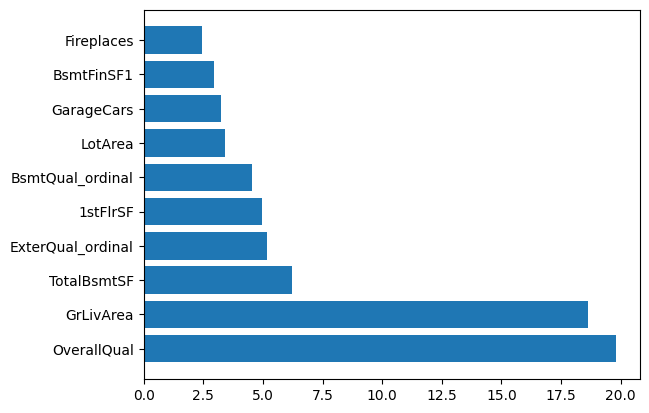

In [68]:
temp = cb_feature_importance_final.iloc[:10,]
plt.barh(temp["feature"], temp["importance_cb_5fk"]);

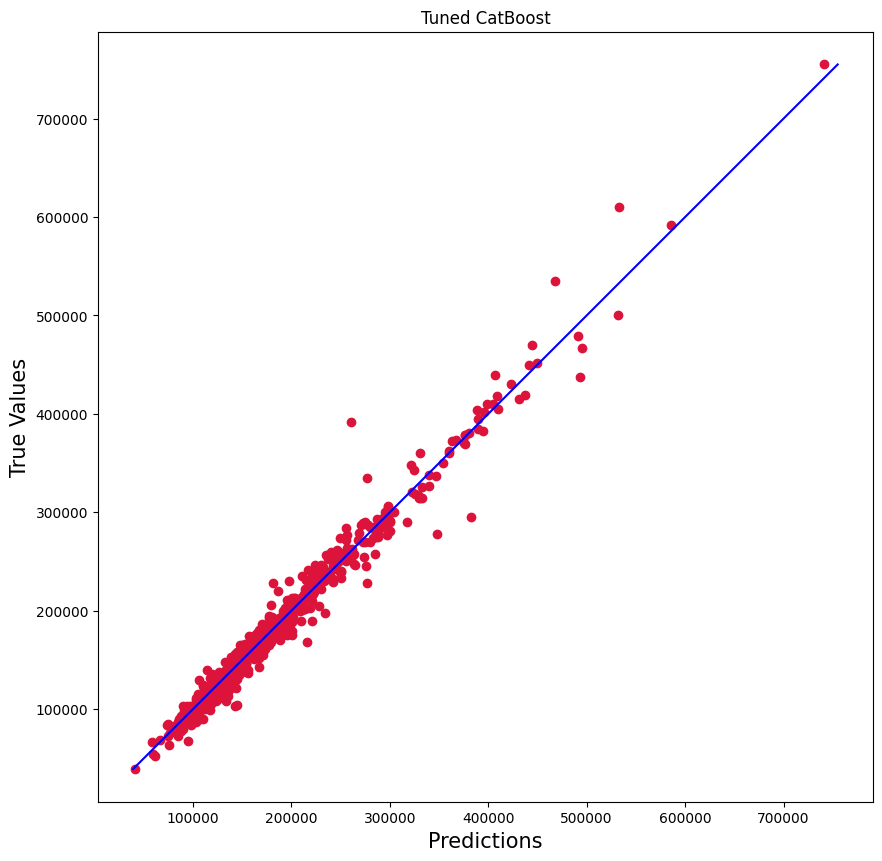

In [69]:
plt.figure(figsize=(10,10))
plt.scatter(y_test_pred, y_test, c='crimson')

plt.title('Tuned CatBoost')
p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('True Values', fontsize=15)
plt.axis('equal')
plt.show()

## Ditch below and add model evaluation session:

That's an excellent question. You're thinking about the stability and reliability of your final model, which is a critical part of the machine learning workflow.

You've already established a strong process for building and evaluating a single, well-tuned model. To go a step further and test its stability, you can use a technique called **bootstrap aggregation**, which is at the heart of models like Random Forest. You can also explore residual plots and other error metrics to gain a deeper understanding of your model's weaknesses.

---

### Method 1: Bootstrap Aggregation (Bootstrapping)

Bootstrapping is a resampling technique that involves repeatedly drawing random samples **with replacement** from your dataset. You can use this to train multiple models and see how stable your performance metric (like RMSE) is across these different training sets. This tells you how sensitive your model's performance is to the specific data it's trained on.

Here's how to do it:

1.  **Loop and Resample**: Create a loop that runs, say, 100 times.
2.  **Draw a Sample**: In each iteration, take a bootstrap sample of your training data. The size of this sample should be equal to the size of your original training data.
3.  **Train and Evaluate**: For each sample, train a new CatBoost model using the best hyperparameters you found earlier.
4.  **Store the Score**: Evaluate this new model on your held-out test set and store the RMSE.
5.  **Analyze the Distribution**: After the loop finishes, you'll have a distribution of 100 RMSE scores.

By analyzing the distribution of these scores, you can get:

* **Average Performance**: The mean of the distribution gives you an even more robust estimate of your model's expected performance.
* **Performance Stability**: The standard deviation of the scores tells you how much the model's performance varies with different training data. A small standard deviation indicates a very stable model.

### Method 2: Residual Analysis

Another powerful way to test the stability and understand the behavior of your final model is to perform a **residual analysis**. Residuals are the differences between the actual house prices and your model's predicted prices ($residuals = y_{actual} - y_{predicted}$).

By plotting the residuals, you can identify patterns where your model might be systematically making errors.

1.  **Plot Residuals vs. Predicted Values**: A common plot is a scatter plot with predicted values on the x-axis and residuals on the y-axis.
    * **Ideal Plot**: The points should be randomly scattered around the zero line, forming a uniform band. This indicates that your model's errors are random and not dependent on the predicted price.
    * **Warning Signs**: If you see a pattern (e.g., a "fanning out" shape where residuals get larger for higher-priced houses), it means your model is less accurate for certain price ranges. This could indicate a need for more data, different features, or a more complex model. 

2.  **Plot Residuals vs. Features**: Plotting residuals against your features can reveal if your model is consistently under- or over-predicting for specific feature values. For example, plotting residuals against `GrLivArea` might show that your model consistently under-predicts the price for very large homes.

---

### Other Metrics and Comparisons

Finally, beyond RMSE, you can use other metrics to get a more complete picture of your model's performance:

* **Mean Absolute Error (MAE)**: This metric is less sensitive to outliers than RMSE. It gives you the average absolute difference between predicted and actual prices. A combination of low RMSE and MAE suggests a robust model with few large errors.
* **R-squared ($R^2$)**: While not ideal for tuning, the final $R^2$ score on the test set is an excellent way to see how much of the variance in house prices is explained by your model.
* **Baseline Comparison**: Your initial instinct was spot-on. Compare your final model's RMSE directly to your baseline model's average cross-validated RMSE. This provides a clear, quantitative measure of the value added by your hyperparameter tuning.

### Residual Plot
- After training your final CatBoost model and using it to make predictions on the test set, you can generate a residual plot to visually inspect its performance. This type of plot is a valuable tool for understanding if your model's errors are random or if there are systematic patterns.

- The plot below shows the relationship between your model's predicted values and the residuals (the difference between the actual and predicted values).

- An ideal residual plot will show a random, uniform scatter of points around the horizontal line at y=0. This indicates that your model's errors are random and are not related to the predicted value. It means your model is not systematically over- or under-predicting for certain ranges of house prices.

- In contrast, if you see a discernible pattern in the plot (e.g., a fanning-out shape, a curve, or a clear concentration of points), it suggests that your model may have a bias. For example, a fanning-out pattern could mean that the model's errors increase as the predicted price gets higher, indicating a need for a more complex model or additional features to handle higher-priced homes.

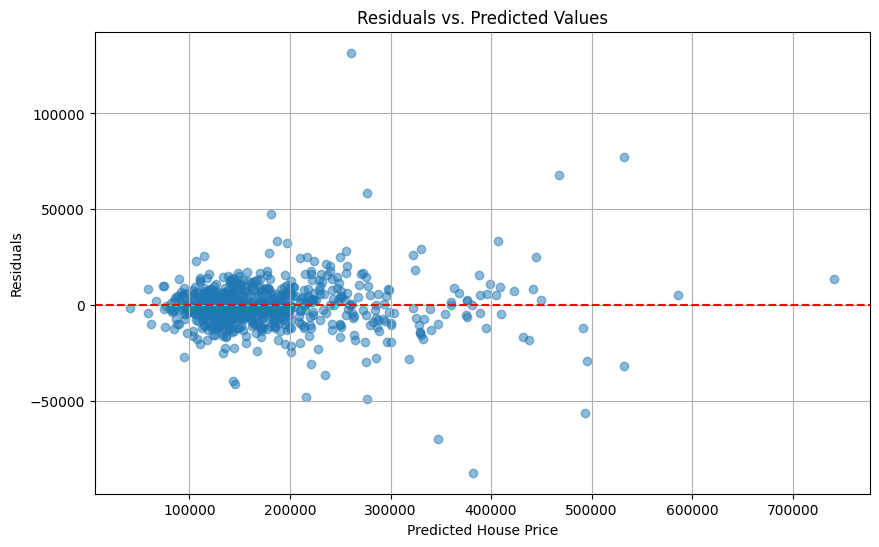

In [82]:
# Plot Residuals vs. Predicted Values

residuals = y_test - y_test_pred

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted House Price')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()
#plt.savefig('residuals_plot.png')

#print("Residuals plot has been generated and saved as 'residuals_plot.png'.")

### Distribution of actual house prices, y_test and y_test_pred
- Overlap: The more the two distributions overlap, the better your model's predictions align with the actual values. An ideal model's y_pred distribution will closely mimic the y_test distribution.

- Shape: The shapes of the two distributions should be similar. If the y_pred distribution is much narrower than the y_test distribution, it means your model is under-predicting the range of prices and is not confident in making predictions for the highest or lowest-priced homes.

- Skewness: If the actual data is skewed (e.g., towards higher prices), your predicted data should show a similar skew.

In [93]:
# Calculate the mean and standard deviation
y_test_mean = np.mean(y_test)
y_test_std = np.std(y_test)
y_test_pred_mean = np.mean(y_test_pred)
y_test_pred_std = np.std(y_test_pred)

print("Actual Values (y_test) statistics:")
print(f"Mean: {y_test_mean:.4f}")
print(f"Standard Deviation: {y_test_std:.4f}")
print("\nPredicted Values (y_test_pred) statistics:")
print(f"Mean: {y_test_pred_mean:.4f}")
print(f"Standard Deviation: {y_test_pred_std:.4f}")

Actual Values (y_test) statistics:
Mean: 180821.2693
Standard Deviation: 82172.3158

Predicted Values (y_test_pred) statistics:
Mean: 181255.8346
Standard Deviation: 80888.1090


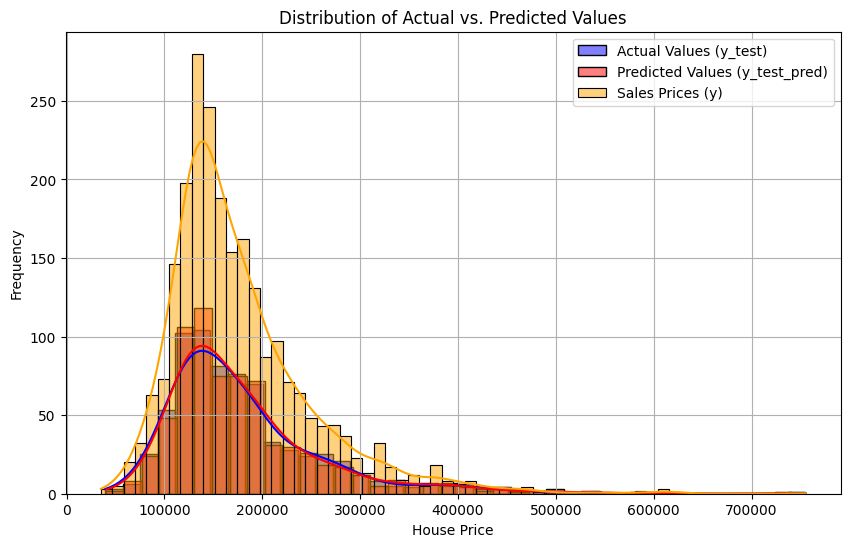

In [89]:
# Plot the distributions of y_test and y_test_pred
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Actual Values (y_test)')
sns.histplot(y_test_pred, kde=True, color='red', label='Predicted Values (y_test_pred)')
sns.histplot(y, kde=True, color='orange', label='Sales Prices (y)')

plt.title('Distribution of Actual vs. Predicted Values')
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
#plt.savefig('distribution_plot.png')

#print("Distribution plot has been generated and saved as 'distribution_plot.png'.")

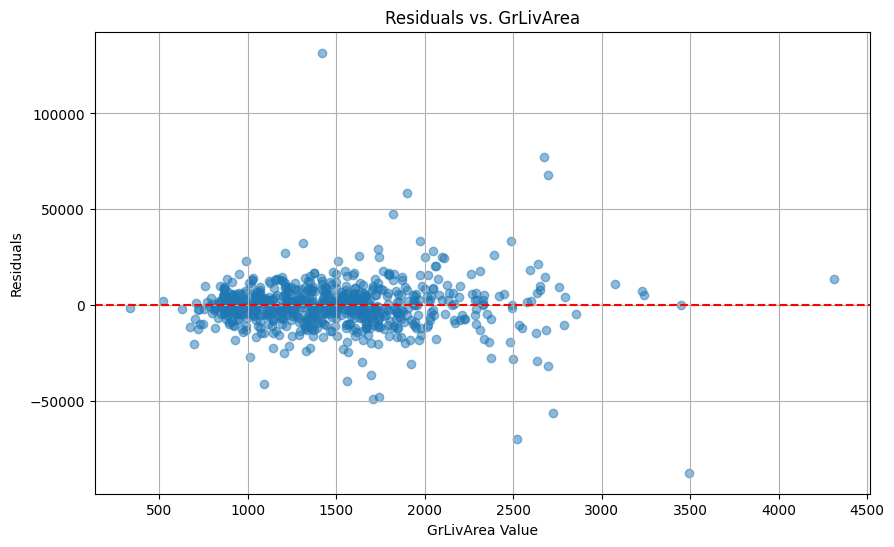

In [91]:
# plot residual vs features

# Choose the feature you want to plot against
feature_to_plot = 'GrLivArea'  # Change this to your desired feature (e.g., 'GrLivArea')
feature_values = X_test[feature_to_plot]

# Create the scatter plot of residuals vs. a chosen feature
plt.figure(figsize=(10, 6))
plt.scatter(feature_values, residuals, alpha=0.5)
plt.title(f'Residuals vs. {feature_to_plot}')
plt.xlabel(f'{feature_to_plot} Value')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()
#plt.savefig(f'residuals_vs_{feature_to_plot}.png')

#print(f"Residuals vs. {feature_to_plot} plot has been generated and saved.")

In [101]:
from sklearn.utils import resample

# --- 3. Perform Bootstrapping to Assess Stability ---
n_bootstraps = 100 # Number of bootstrap samples to create
rmse_scores = []   # List to store the RMSE score for each bootstrap run

#print(f"Starting bootstrapping with {n_bootstraps} iterations...")

for i in range(n_bootstraps):
    # a. Create a bootstrap sample of the training data
    # resample() draws a random sample with replacement
    X_sample, y_sample = resample(X_train, y_train, replace=True, random_state=i)

    # b. Train a new CatBoost model on the bootstrap sample
    # The model uses the best_params found during hyperparameter tuning
    model = CatBoostRegressor(**best_params, verbose=0, random_state=42, cat_features=categ_nom)
    model.fit(X_sample, y_sample)

    # c. Evaluate the model on the held-out test set
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # d. Store the RMSE score
    rmse_scores.append(rmse)

    # Print progress every 10 iterations
    if (i + 1) % 10 == 0:
        print(f"Completed iteration {i + 1}/{n_bootstraps}")

# --- 4. Analyze the Distribution of RMSE Scores ---
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
min_rmse = np.min(rmse_scores)
max_rmse = np.max(rmse_scores)

print("\n--- Bootstrapping Results ---")
print(f"Average RMSE from {n_bootstraps} runs: {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")
print(f"Minimum RMSE: {min_rmse:.4f}")
print(f"Maximum RMSE: {max_rmse:.4f}")

Completed iteration 10/100
Completed iteration 20/100
Completed iteration 30/100
Completed iteration 40/100
Completed iteration 50/100
Completed iteration 60/100
Completed iteration 70/100
Completed iteration 80/100
Completed iteration 90/100
Completed iteration 100/100

--- Bootstrapping Results ---
Average RMSE from 100 runs: 19735.8285
Standard Deviation of RMSE: 1067.8939
Minimum RMSE: 17811.7607
Maximum RMSE: 22268.2189


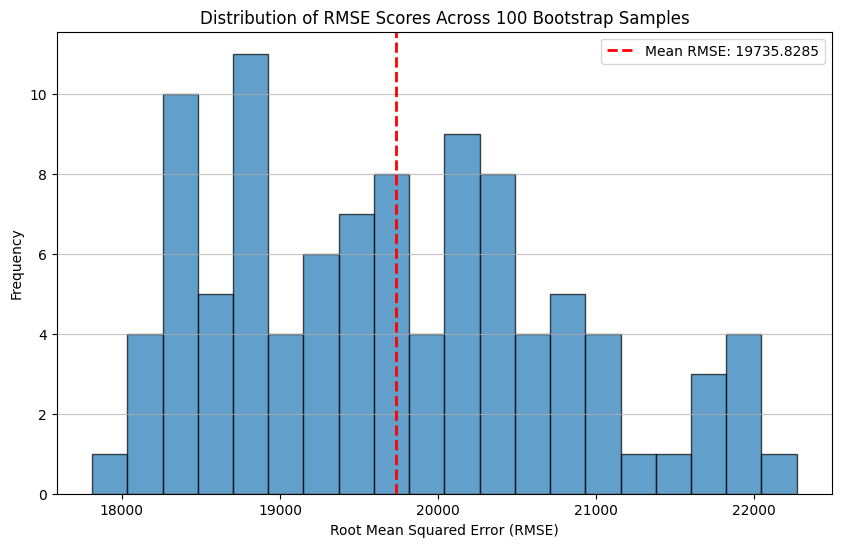

In [102]:
# --- 5. Visualize the Distribution ---
plt.figure(figsize=(10, 6))
plt.hist(rmse_scores, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(mean_rmse, color='r', linestyle='dashed', linewidth=2, label=f'Mean RMSE: {mean_rmse:.4f}')
plt.title(f'Distribution of RMSE Scores Across {n_bootstraps} Bootstrap Samples')
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

### SHAP
- A SHAP value tells you how much a particular feature pushes the model’s predicted house price up or down, compared to the average prediction across the dataset.

In [ ]:
# Say the average predicted price is $200,000
# If for House A, the SHAP value for GrLivArea is +15,000, 
# that means the model believes the GrLivArea of House A contributes +$15,000 to the price, 
# compared to the average. If for House B, the SHAP value is -5,000, 
# that means the GrLivArea of House B is lowering the prediction by $5,000 from the average.

In [73]:
import shap

# Fit explainer on train data
explainer = shap.Explainer(final_model)

# Evaluate SHAP values on test set
shap_values = explainer.shap_values(X_test)

#This balances accurate attribution with realistic performance evaluation.

In [75]:
# SHAP feature importance
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for easier viewing and sorting
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap_cb_5fk': mean_abs_shap_values
})

# Sort in descending order
shap_importance_sorted = shap_importance.sort_values(by='mean_abs_shap_cb_5fk', ascending=False)

# Display
print(shap_importance_sorted.head(30))

# how to interpret:
# # On average, the feature OverallQual changes the model’s prediction by 14,566 units of currency (likely dollars), 
# either increasing or decreasing the predicted house price.

                 feature  mean_abs_shap_cb_5fk
0              GrLivArea          15187.101961
15           OverallQual          10455.929832
27           TotalBsmtSF           5232.550270
31              1stFlrSF           4476.463264
4                LotArea           4240.778454
24            BsmtFinSF1           4044.398001
74     ExterQual_ordinal           3603.395361
16           OverallCond           3531.143924
41            Fireplaces           3046.527796
68      BsmtQual_ordinal           2904.995241
12          Neighborhood           2886.623704
67   KitchenQual_ordinal           2694.257282
17             YearBuilt           2591.713823
44            GarageCars           2508.141101
64   FireplaceQu_ordinal           2071.294338
71  BsmtFinType1_ordinal           1968.226345
37              HalfBath           1681.157261
32              2ndFlrSF           1670.314420
22            MasVnrArea           1612.210993
45            GarageArea           1412.753853
60  GarageFin

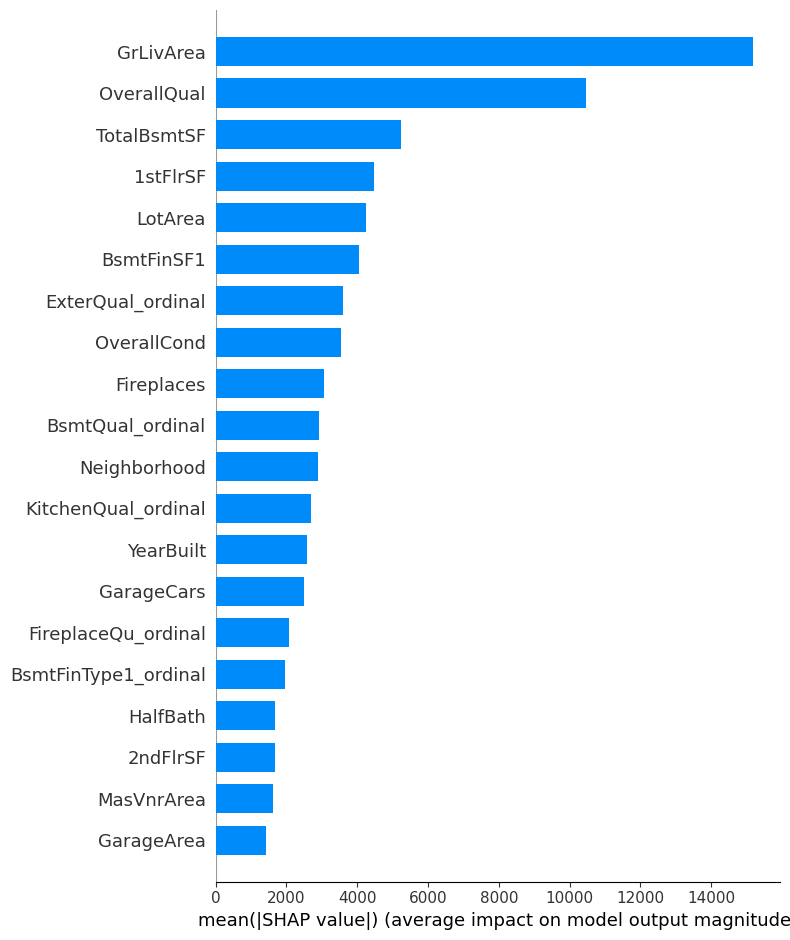

In [76]:
# to visualize the mean abs of SHAP value using summary bar plot
shap.summary_plot(shap_values, X_test, plot_type='bar')

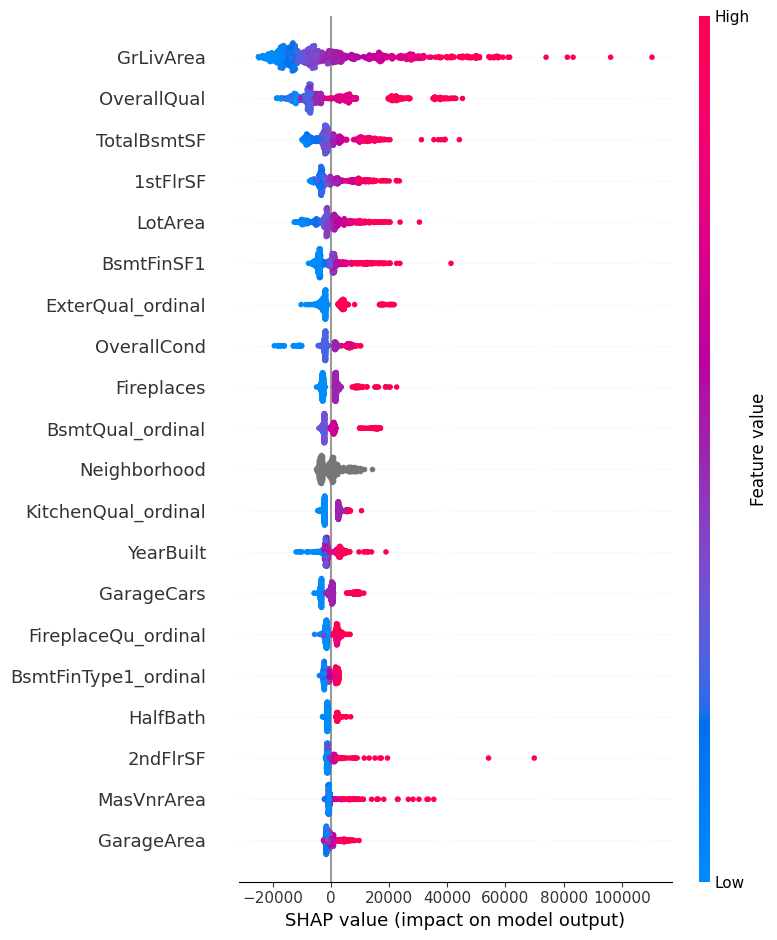

In [77]:
# summary violin plot
shap.summary_plot(shap_values, X_test)

In [ ]:
# How to Read the Violin Plot
# ✅ 1. Width of the Violin (Horizontal Spread)

# Wider areas indicate more data points with similar SHAP values.

# This shows the distribution of how much that feature affects predictions across your dataset.

# ✅ 2. Color Gradient (Red → Blue)

# Each dot is colored by the actual value of the feature:

# Red = High feature value

# Blue = Low feature value

# This helps you understand the direction of the effect.

# For example, if red dots are mostly on the right (positive SHAP values), high values of that feature increase the prediction (e.g., higher price).

# If blue dots are on the left (negative SHAP values), low values decrease the prediction.

# ✅ 3. X-Axis (SHAP Value)

# Represents the magnitude and direction of impact on the model’s prediction.

# A value of +5000 means the feature adds $5,000 (for a house price model).

# A value of -3000 means it subtracts $3,000 from the prediction.

### SHAP Dependence Plot
- In a SHAP dependence plot, the x-axis shows the value of the feature you specified, and the y-axis shows the SHAP value (i.e., the feature’s contribution to the model output). But if you’re seeing a second feature encoded on the plot, that’s expected and by design. The second feature (by color) is there to show interactions. The SHAP dependence plot automatically colors the points by the most correlated feature with the one on the x-axis. This helps uncover interactions between features.

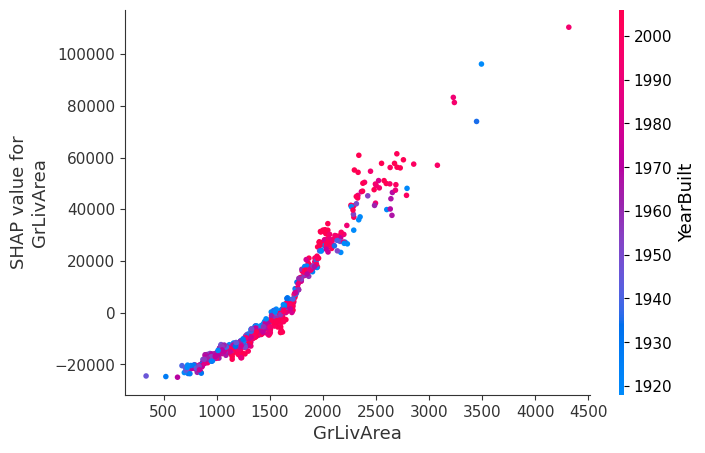

In [78]:
shap.dependence_plot('GrLivArea', shap_values, X_test)

# if don't want to show the second y-axis
#shap.dependence_plot('GrLivArea', shap_values, x_test, interaction_index=None)

<Figure size 600x400 with 0 Axes>

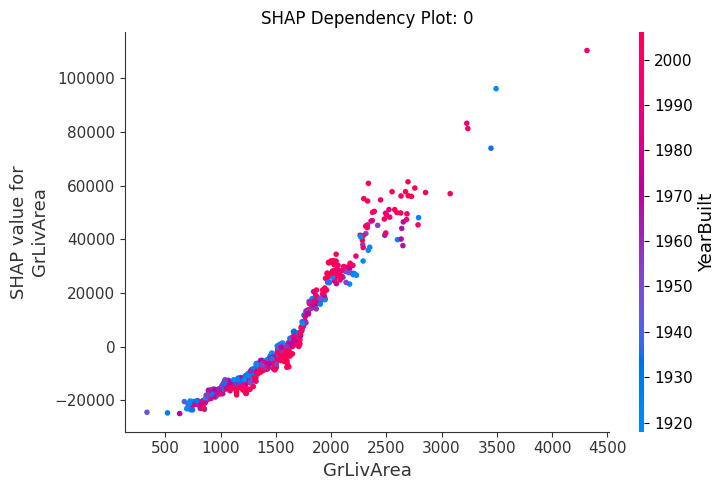

<Figure size 600x400 with 0 Axes>

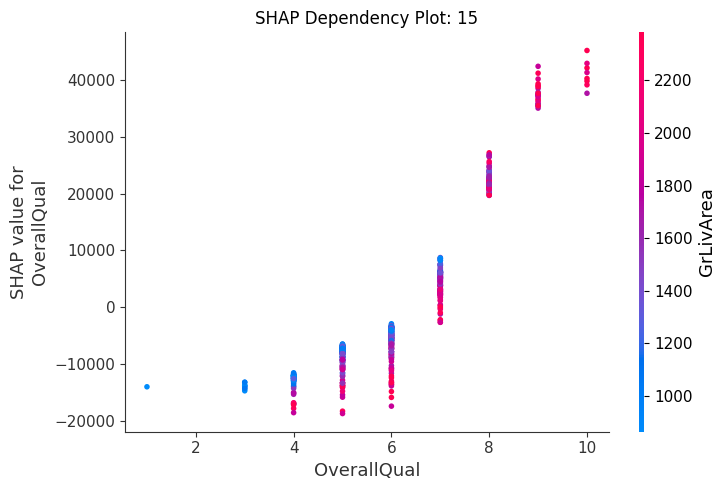

<Figure size 600x400 with 0 Axes>

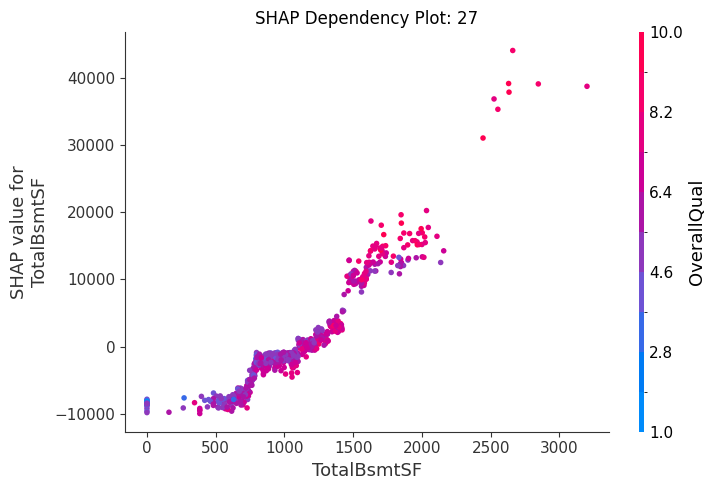

<Figure size 600x400 with 0 Axes>

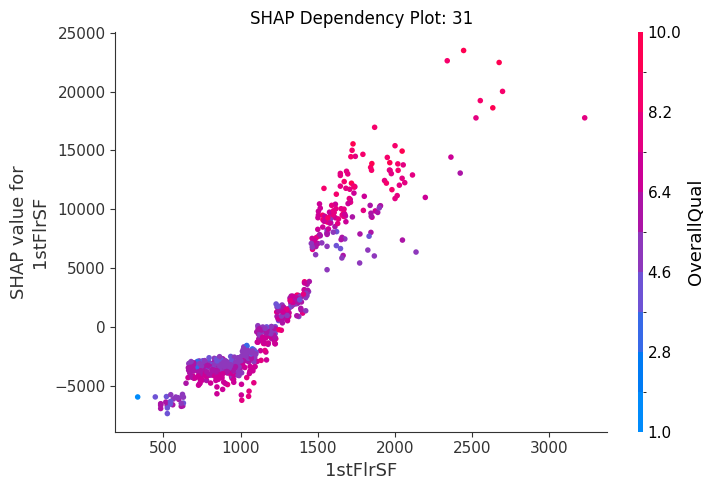

<Figure size 600x400 with 0 Axes>

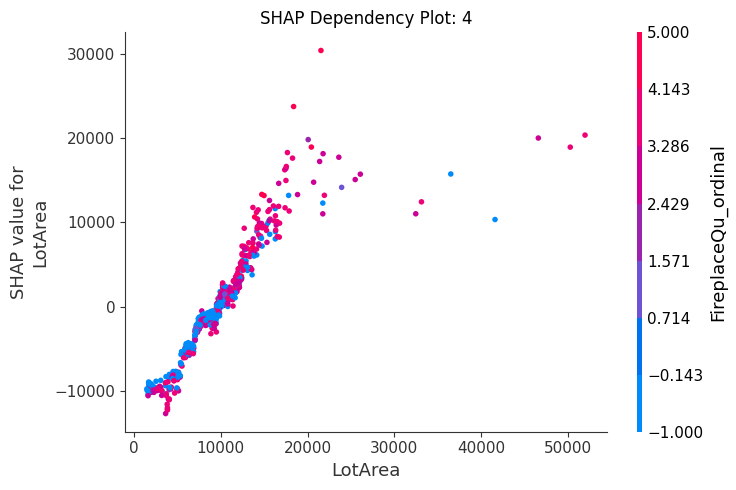

<Figure size 600x400 with 0 Axes>

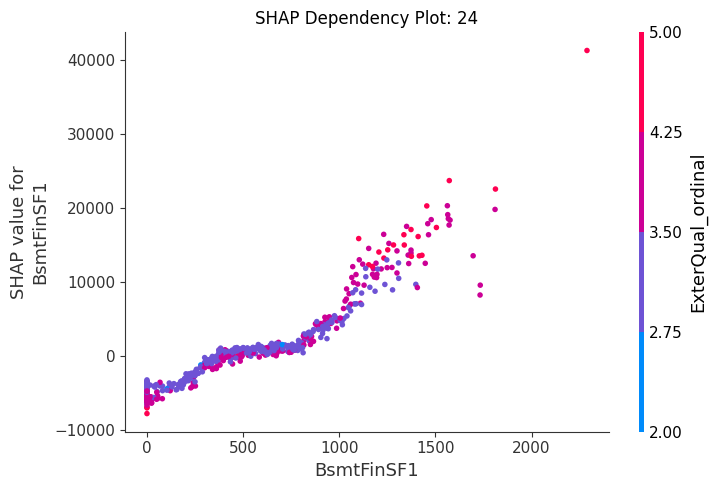

<Figure size 600x400 with 0 Axes>

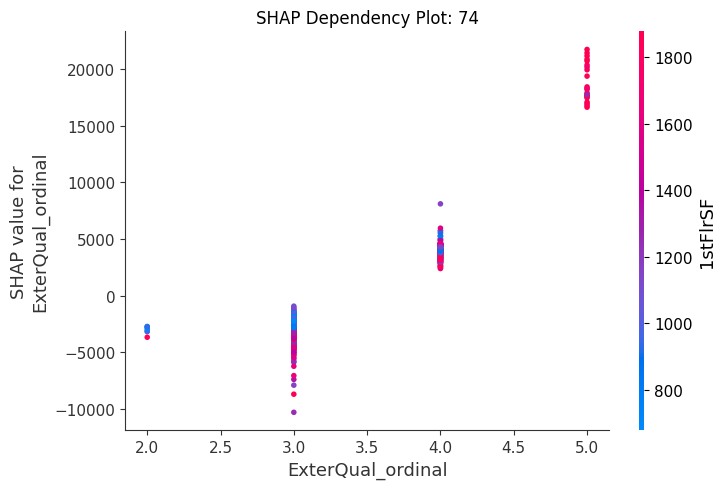

<Figure size 600x400 with 0 Axes>

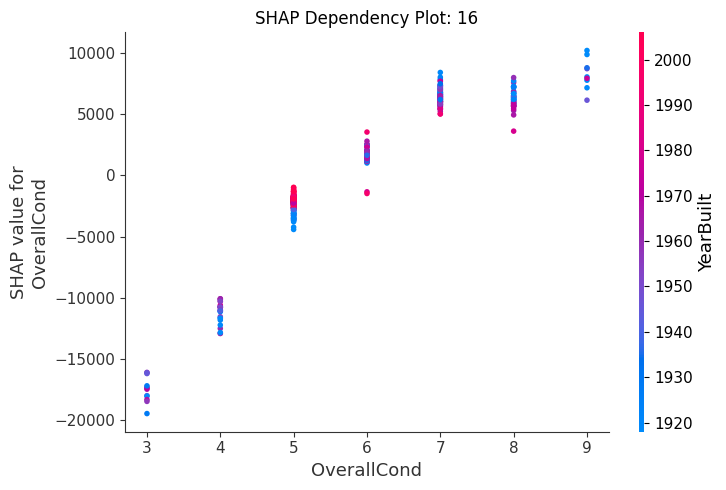

<Figure size 600x400 with 0 Axes>

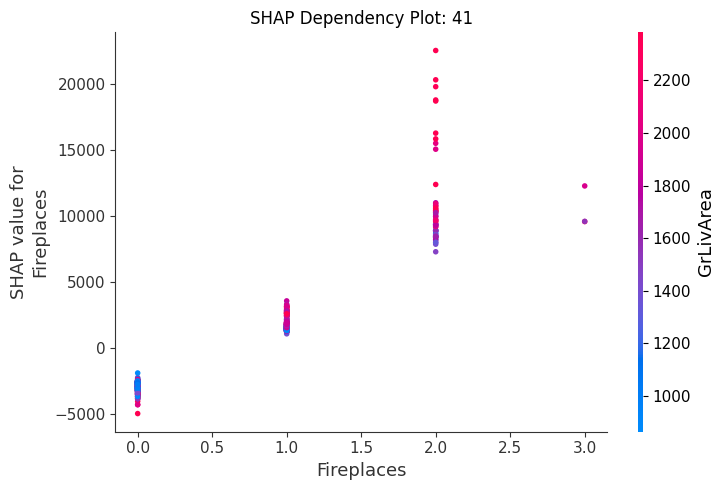

<Figure size 600x400 with 0 Axes>

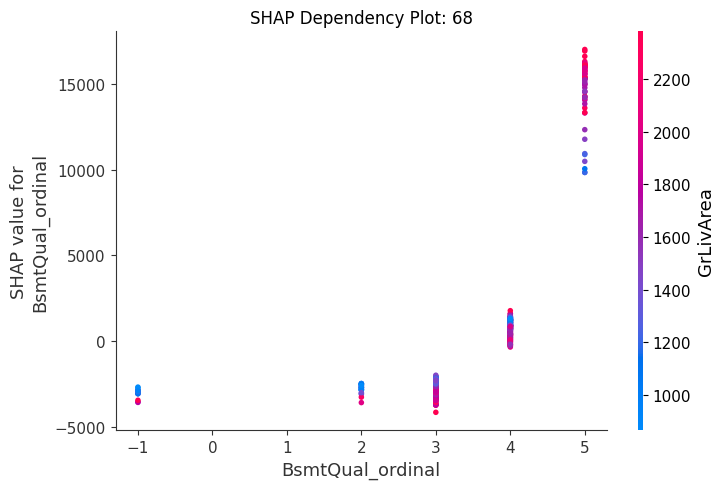

<Figure size 600x400 with 0 Axes>

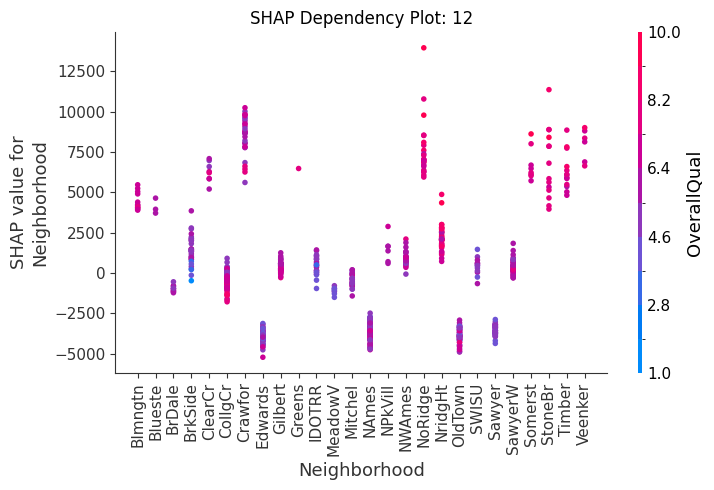

<Figure size 600x400 with 0 Axes>

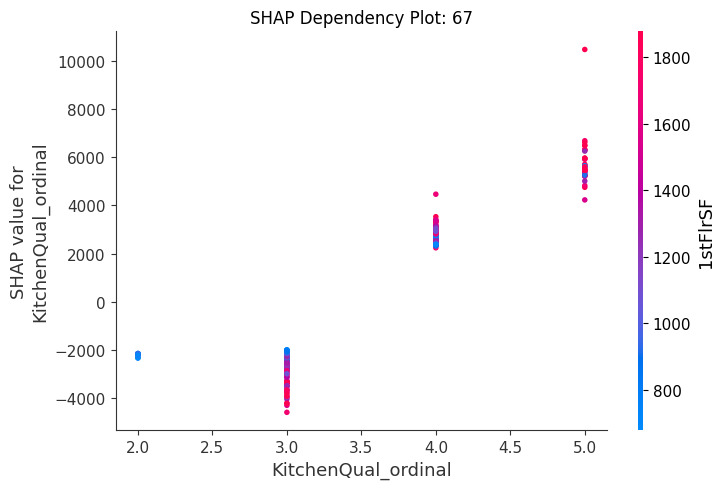

<Figure size 600x400 with 0 Axes>

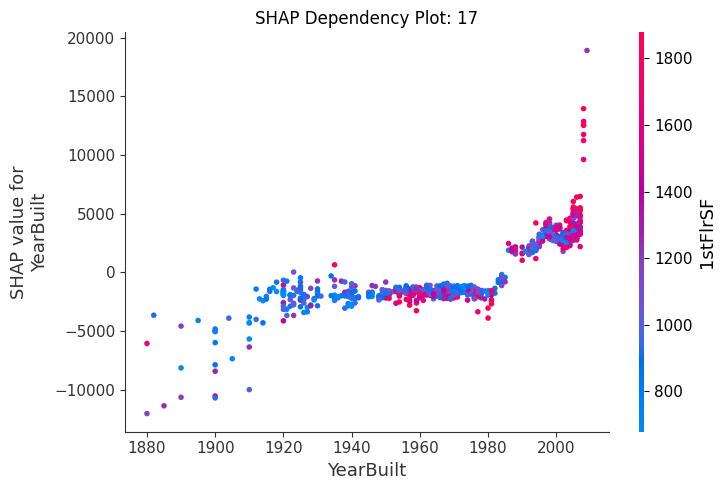

<Figure size 600x400 with 0 Axes>

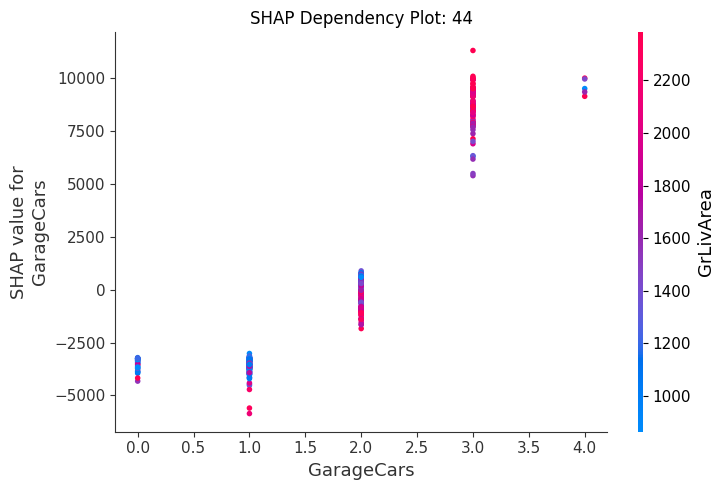

<Figure size 600x400 with 0 Axes>

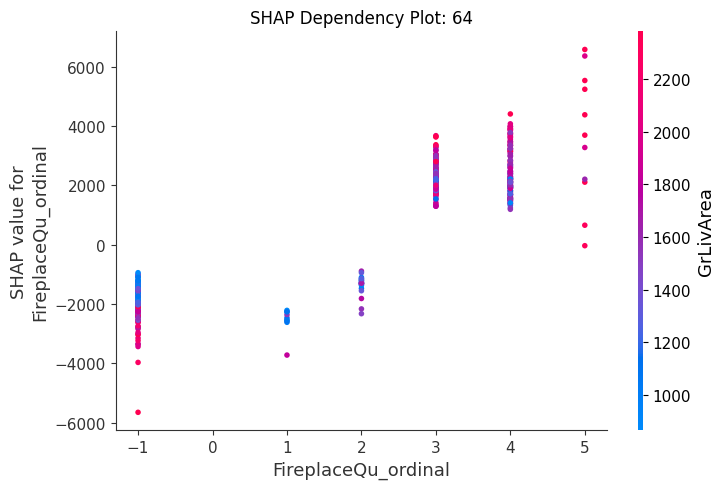

<Figure size 600x400 with 0 Axes>

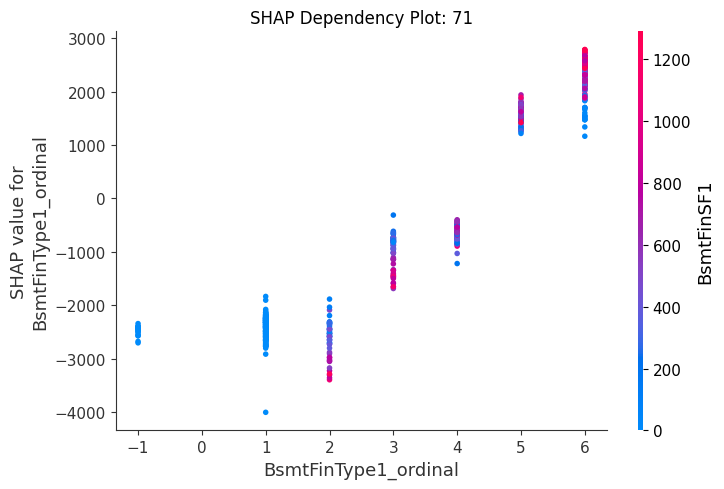

<Figure size 600x400 with 0 Axes>

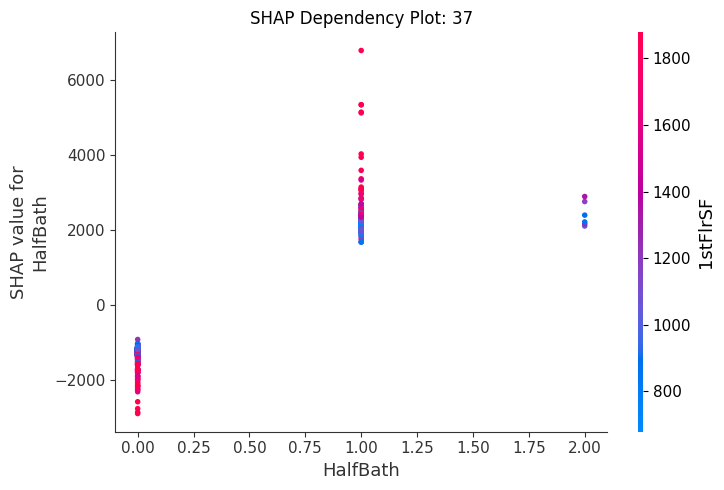

<Figure size 600x400 with 0 Axes>

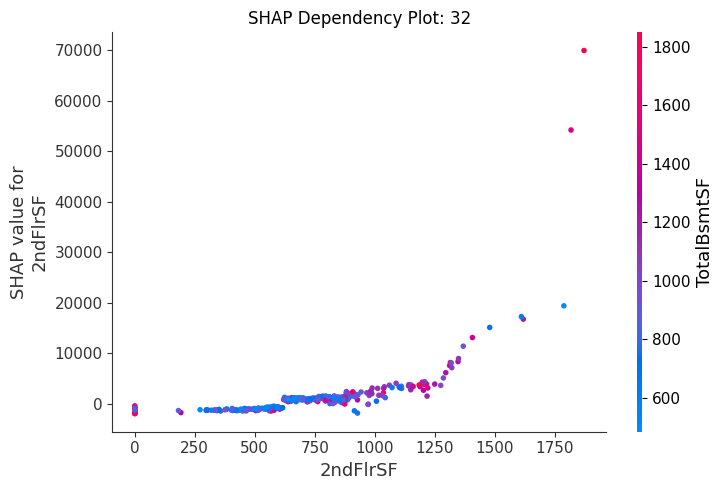

<Figure size 600x400 with 0 Axes>

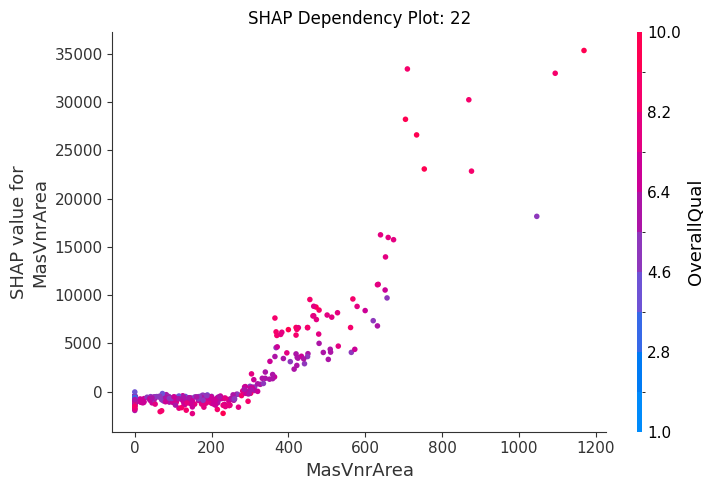

<Figure size 600x400 with 0 Axes>

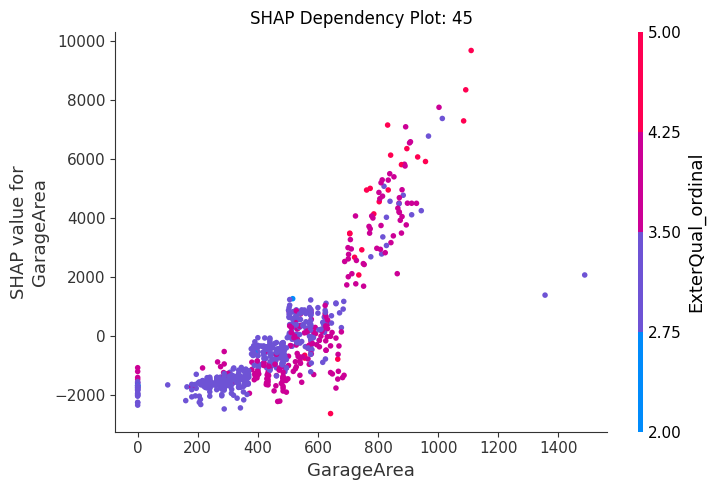

In [79]:
# Select top 20 features
top_features = shap_importance_sorted.head(20).index.tolist()

for feature in top_features:
    plt.figure(figsize=(6, 4))  # Compact size
    
    shap.dependence_plot(
        feature,
        shap_values,
        X_test,
        #interaction_index=None,  # Auto-picks a good feature for color encoding
        show=False
    )
    plt.title(f"SHAP Dependency Plot: {feature}")
    plt.tight_layout()
    plt.show()
    
    # Save plot to file
#     filename = f"shap_dependency_{feature}.png"
#     plt.savefig(filename, dpi=150)
#     plt.close()

# how to interpret
# using OverallQual as an example,
# 1stFlrSF is the most correlated feature with Overall
# you can see larger homes with high OverallQual have even higher SHAP values (strong positive synergy).
# Conversely, small homes (blue dots) with high OverallQual may still not be valued as highly.

### Export lists for final model comparison

### Extract the list of features and features that each one is most correlated with

In [99]:
# Compute correlation matrix for SHAP dependency plot coloring
#cor_matrix = X_test.corr()

In [175]:
# most_correlated = {}

# for feature in x_test.columns:
#     # Exclude self-correlation
#     corrs = cor_matrix[feature].drop(labels=[feature])
    
#     # Drop NaNs
#     corrs = corrs.dropna()
    
#     # Get feature with highest absolute correlation
#     if not corrs.empty:
#         most_correlated_feature = corrs.abs().idxmax()
#         most_correlated[feature] = most_correlated_feature


In [176]:
# correlation_df = pd.DataFrame.from_dict(most_correlated, orient='index', columns=['Most_Correlated_Feature'])
# correlation_df.reset_index(inplace=True)
# correlation_df.columns = ['feature', 'most_correlated_feature_xgb_5fk']

In [177]:
# correlation_df

,feature,most_correlated_feature_xgb_5fk
0,GrLivArea,TotRmsAbvGrd
1,LotFrontage,1stFlrSF
2,LotArea,Street_Pave
3,OverallQual,ExterQual_ordinal
4,OverallCond,YearBuilt
...,...,...
227,Electrical_FuseP,LotShape_IR3
228,Electrical_SBrkr,CentralAir_Y
229,QrtSold_Q2,QrtSold_Q3
230,QrtSold_Q3,MoSold_7


In [178]:
# limit the above list to top 20 features ranked by mean abs SHAP values
# xgb_SHAP_feature_final = pd.merge(
#     shap_importance_sorted, 
#     correlation_df, 
#     how='left',
#     on = 'feature'
# )

# xgb_SHAP_feature_final

,feature,mean_abs_shap_xgb_5fk,most_correlated_feature_xgb_5fk
0,OverallQual,23269.126953,ExterQual_ordinal
1,GrLivArea,13396.876953,TotRmsAbvGrd
2,TotalBsmtSF,5408.382324,1stFlrSF
3,LotArea,3566.944336,Street_Pave
4,1stFlrSF,3462.946045,TotalBsmtSF
...,...,...,...
276,exterior_covering_MetalSd_HdBoard,0.000000,condition_Feedr_Norm
277,exterior_covering_MetalSd_Stucco,0.000000,Heating_GasW
278,exterior_covering_MetalSd_VinylSd,0.000000,Neighborhood_SWISU
279,exterior_covering_MetalSd_Wd Sdng,0.000000,NaN


In [179]:
#xgb_feature_importance_final

,feature,importance_xgb_5fk
24,GarageCars,0.262229
3,OverallQual,0.212933
47,ExterQual_ordinal,0.112570
42,BsmtQual_ordinal,0.042960
0,GrLivArea,0.026702
...,...,...
152,exterior_covering_Plywood_HdBoard,0.000000
153,exterior_covering_Plywood_ImStucc,0.000000
154,exterior_covering_Plywood_VinylSd,0.000000
155,exterior_covering_Plywood_Wd Sdng,0.000000
